<img src="https://www.brickunderground.com/sites/default/files/styles/blog_primary_image/public/blog/images/4859177053_c3fb190917_o.jpg" width = 100% >

In [1]:
import numpy as np 
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
% matplotlib inline
import os
print(os.listdir("../input"))

['sample_submission.csv', 'test.csv', 'GCP-Coupons-Instructions.rtf', 'train.csv']


*** Load Data**

In [2]:
# read data in pandas dataframe
df_train =  pd.read_csv('../input/train.csv',nrows= 5000000,parse_dates=["pickup_datetime"])

# list first few rows (datapoints)
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


*** Glimpse of Data**

In [3]:
df_train.columns.values

array(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'], dtype=object)

In [4]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


In [5]:
df_train.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

*** Check for Missing Data**

In [6]:
df_train.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    36
dropoff_latitude     36
passenger_count       0
dtype: int64

In [7]:
df_train = df_train.dropna()

*** Preknoledges and Findings based on the Dataset:**

*     Initial charge: $2.50 ( Taxi fares begin at $2.50 regardless of distance)

*     Mileage: 40 cents per 1/5 mile

*     Waiting charge: 40 cents per 120 seconds

*     JFK flat fare: $45. (was $35)

*     Newark surcharge: $15. (was $10) 4 p.m.–8 p.m. weekday

*     The coordinate system  is bounded by (-90,90) for latitude and (-90,90) for longitude, so anything outside this range is an error 

*     Locations where drivers pick you up from shouldn't be the same locations where they drop you off at.

*    Any value that is unrealistic or abnormal should be treated as an outlier


*** Trip Distance**

In [8]:
#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [9]:
df_train['trip_distance']=df_train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

In [10]:
df_train['trip_distance'].head(10)

0    0.640487
1    5.250670
2    0.863411
3    1.739386
4    1.242218
5    2.353281
6    0.966733
7    2.582073
8    0.778722
9    1.770676
Name: trip_distance, dtype: float64

In [11]:

# Cab rides should not have negative numbers, along with that, taxi standarad fares begin at $2.50
df_train = df_train[df_train['fare_amount'] >= 2.5]
    
# our latitude and longitude should not be equal to 0 becuase the dataset is based in NY
df_train = df_train[df_train['pickup_latitude']!= 0]
df_train = df_train[df_train['pickup_longitude'] != 0]
df_train = df_train[df_train['dropoff_latitude'] != 0]
df_train = df_train[df_train['dropoff_longitude'] != 0]

# latitude and longitude are bounded by 90 and -90. We shouldnt have any coordiantes out of that range
df_train = df_train[(df_train['pickup_latitude']<=90) & (df_train['pickup_latitude']>=-90)]
df_train = df_train[(df_train['pickup_longitude']<=90) & (df_train['pickup_longitude']>=-90)]
df_train = df_train[(df_train['dropoff_latitude']<=90) & (df_train['dropoff_latitude']>=-90)]
df_train = df_train[(df_train['dropoff_longitude']<=90) & (df_train['dropoff_longitude']>=-90)]
    
# I dont want to include destinations that have not moved from there pickup coordinates to there dropoff coordinates
df_train = df_train[(df_train['pickup_latitude'] != df_train['dropoff_latitude']) & (df_train['pickup_longitude'] != df_train['dropoff_longitude'])]

In [12]:
# list first few rows (datapoints)
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.640487
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,5.250670
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,1.739386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of Fare Amount')

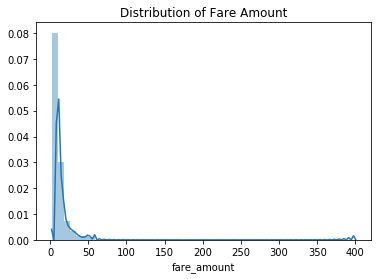

In [20]:
sns.distplot(df_train['fare_amount'])

plt.title('Distribution of Fare Amount')

Text(0.5, 1.0, 'Looking for Outliers with a Boxplot')

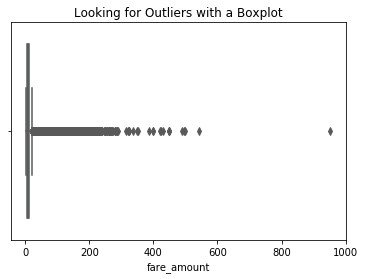

In [16]:
%matplotlib inline
sns.boxplot(df_train['fare_amount'], palette="Set2" )

plt.title('Looking for Outliers with a Boxplot')

In [17]:
df_train = df_train[(df_train['fare_amount'] >= 2.5) & (df_train['fare_amount'] <= 800) ]

In [21]:
mean = np.mean(df_train['fare_amount'])
sd = np.std(df_train['fare_amount'])    
df_train = df_train[(df_train['fare_amount'] > mean - 3*sd) & (df_train['fare_amount'] < mean + 3*sd)]

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distribution of Fare Amount after removing outliers')

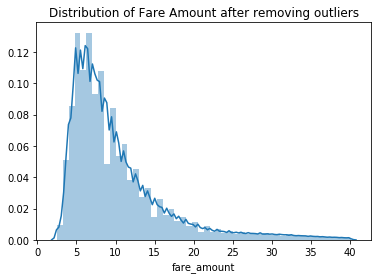

In [22]:
sns.distplot(df_train['fare_amount'])

plt.title('Distribution of Fare Amount after removing outliers')

In [23]:
len(df_train)

4714682

Double check to make sure there are no outliers of coordinate

In [24]:
# Double check the coordinate by adding new features 'abs_diff_longitude' and 'abs_diff_latitude'
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

add_travel_vector_features(df_train)

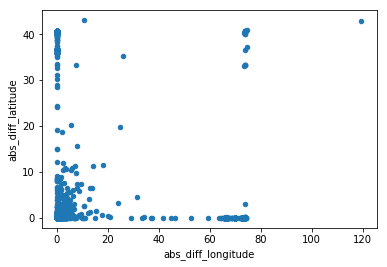

In [25]:
plot = df_train.iloc[:4714682].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

We expect most of these values to be very small (likely between 0 and 1) since it should all be differences between GPS coordinates within one city. For reference, one degree of latitude is about 69 miles. 

In [27]:
print('Old size: %d' % len(df_train))
df_train = df_train[(df_train.abs_diff_longitude < 5.0) & (df_train.abs_diff_latitude < 5.0)]
print('New size: %d' % len(df_train))

Old size: 4714682
New size: 4713693


*** Exploratory Analysis**

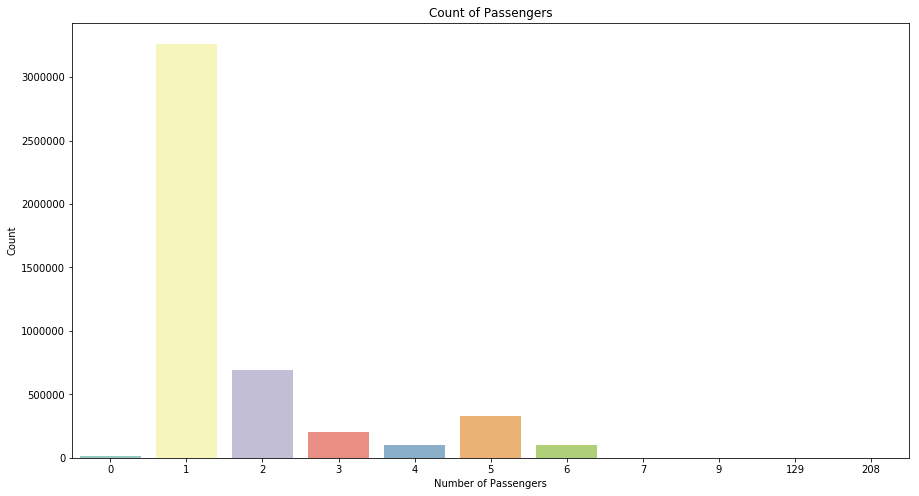

In [28]:
# Check the distribution of "passenger_count"
passenger_count = df_train.groupby(['passenger_count']).count()

fig, ax = plt.subplots(figsize=(15,8))

sns.barplot(passenger_count.index, passenger_count['key'], palette = "Set3")

plt.xlabel('Number of Passengers')
plt.ylabel('Count')
plt.title('Count of Passengers')
plt.show()

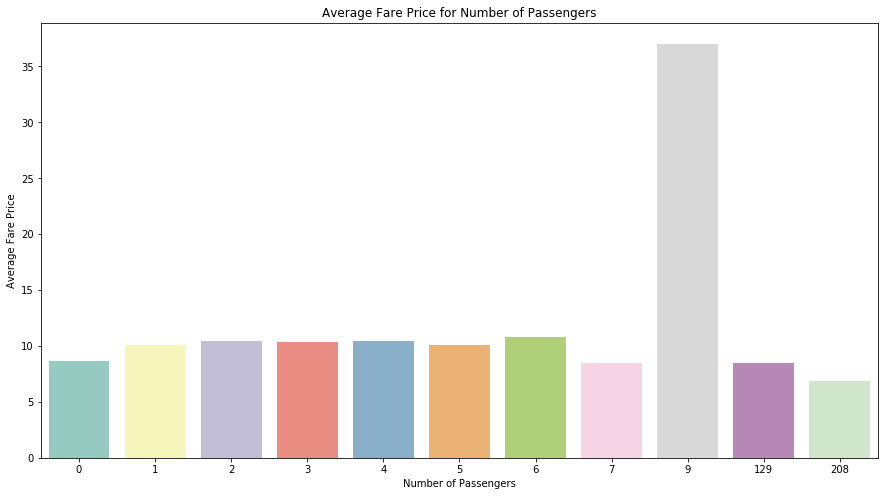

In [29]:
passenger_fare = df_train.groupby(['passenger_count']).mean()

fig, ax = plt.subplots(figsize=(15,8))

sns.barplot(passenger_fare.index, passenger_fare['fare_amount'], palette = "Set3")

plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare Price')
plt.title('Average Fare Price for Number of Passengers')
plt.show()

Remove rows with more than 7 passengers or 0 passenger.

In [30]:
df_train = df_train[(df_train['passenger_count']<=7) & (df_train['passenger_count']>=1)]

* Map Plot

In [31]:
import folium

In [32]:

coordinates = [[40.711303, -74.016048],[40.782004, -73.979268],]

# Create the map and add the line
m = folium.Map(location=[40.730610,-73.935242], zoom_start=12)
my_PolyLine=folium.PolyLine(locations=coordinates,weight=5, color = "black")
m.add_children(my_PolyLine)





/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  import sys


*** Feature Engineering**

In [33]:
# Add some useful features instead of the feature "key" (Date)
def date_columns(data):
    data['key'] = pd.to_datetime(data['key'], yearfirst=True)
    data['year'] = data['key'].dt.year
    data['month'] = data['key'].dt.month
    data['day'] = data['key'].dt.day
    data['weekday'] = data['key'].dt.weekday
    data['hour'] = data['key'].dt.hour
    #data['day_of_week'] = data['key'].dt.day_name()

In [34]:
date_columns(df_train)
df_train.columns.values

array(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'trip_distance', 'abs_diff_longitude',
       'abs_diff_latitude', 'year', 'month', 'day', 'weekday', 'hour'],
      dtype=object)

In [35]:
df_train.dtypes

key                   datetime64[ns]
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
trip_distance                float64
abs_diff_longitude           float64
abs_diff_latitude            float64
year                           int64
month                          int64
day                            int64
weekday                        int64
hour                           int64
dtype: object

In [36]:
df_train.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,abs_diff_longitude,abs_diff_latitude,year,month,day,weekday,hour
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,0.002701,0.009041,2009,6,15,0,17
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,0.036780,0.070701,2010,1,5,1,16
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,0.008504,0.010708,2011,8,18,3,0
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,0.004437,0.024949,2012,4,21,5,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,0.011440,0.015754,2010,3,9,1,7
5,2011-01-06 09:50:45.000000200,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,2.353281,0.028072,0.026603,2011,1,6,3,9
6,2012-11-20 20:35:00.000000100,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,0.966733,0.006200,0.013180,2012,11,20,1,20
7,2012-01-04 17:22:00.000000810,16.5,2012-01-04 17:22:00,-73.951300,40.774138,-73.990095,40.751048,1,2.582073,0.038795,0.023090,2012,1,4,2,17
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00,-74.006462,40.726713,-73.993078,40.731628,1,0.778722,0.013384,0.004915,2012,12,3,0,13
9,2009-09-02 01:11:00.000000830,8.9,2009-09-02 01:11:00,-73.980658,40.733873,-73.991540,40.758138,2,1.770676,0.010882,0.024265,2009,9,2,2,1


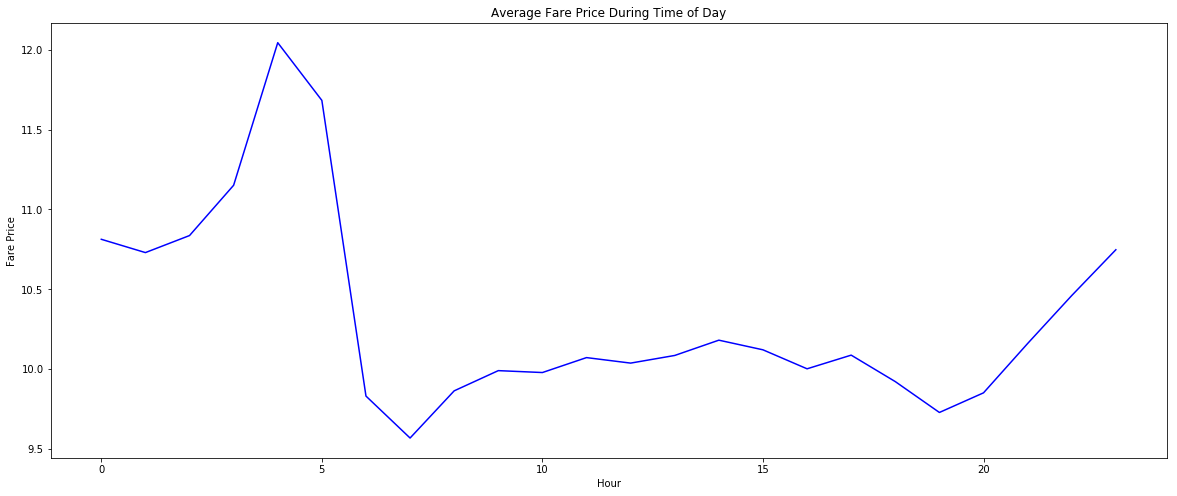

In [37]:
#Hours_Plot
time_of_day = df_train.groupby(['hour']).mean()

plt.figure(figsize=(20,8))
plt.plot(time_of_day.index, time_of_day.fare_amount, color = 'blue')

plt.xlabel('Hour')
plt.ylabel('Fare Price')
plt.title('Average Fare Price During Time of Day')
plt.show()

In [38]:
#Time Series Plot

taxi = df_train.sort_values(by='key').reset_index()

year = taxi['key'].dt.year.astype(str)
month = taxi['key'].dt.month.astype(str)
day = taxi['key'].dt.day.astype(str)

date = year+"-"+month+"-"+day
date = pd.to_datetime(date)
year_month = year +'-'+month
year_month = pd.to_datetime(year_month)
taxi['year_month'] = year_month
taxi['date'] = date


taxi_rate = taxi.groupby(['date']).mean()




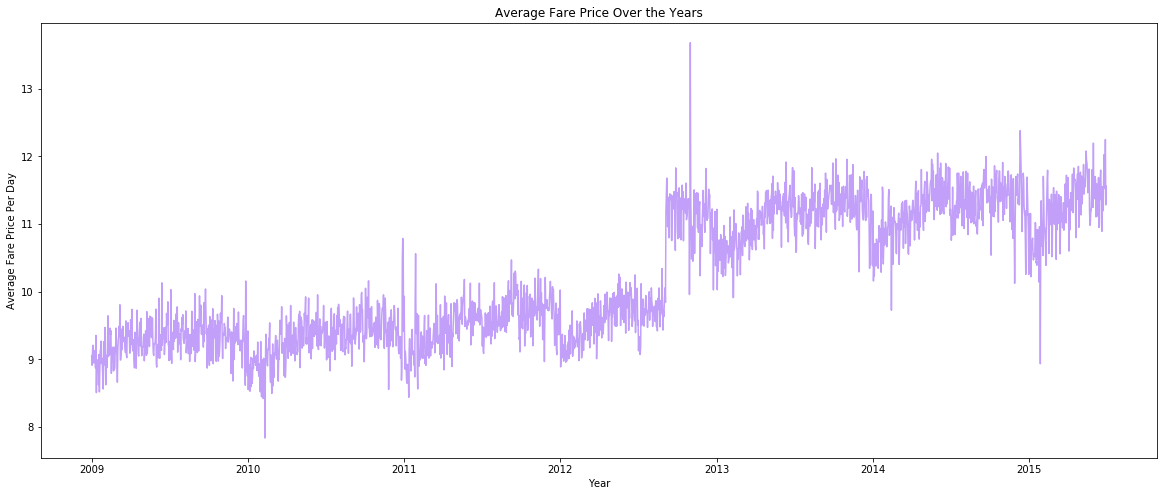

In [39]:

plt.figure(figsize=(20,8))

plt.plot(taxi_rate.index, taxi_rate.fare_amount, color = "#C2A0FA")



plt.xlabel('Year')
plt.ylabel('Average Fare Price Per Day')
plt.title('Average Fare Price Over the Years')
plt.show()

#there had been a significant increase in fare price since 2013.

In [40]:
df_train = df_train[(df_train['year']>=2013)]

df_train.sort_values(by='year',ascending= True)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,abs_diff_longitude,abs_diff_latitude,year,month,day,weekday,hour
13,2013-07-02 19:54:00.000000232,7.00,2013-07-02 19:54:00,-74.005360,40.728867,-74.008913,40.710907,1,1.254787,0.003553,0.017960,2013,7,2,1,19
3723234,2013-10-09 13:57:39.000000300,7.00,2013-10-09 13:57:39,-73.976157,40.776517,-73.961693,40.780491,1,0.805033,0.014464,0.003974,2013,10,9,2,13
1783119,2013-08-20 07:43:32.000000100,8.00,2013-08-20 07:43:32,-73.994540,40.750213,-73.978568,40.756275,1,0.935033,0.015972,0.006062,2013,8,20,1,7
1783120,2013-12-20 00:04:41.000000200,4.00,2013-12-20 00:04:41,-73.956689,40.719067,-73.947194,40.724984,1,0.643699,0.009495,0.005917,2013,12,20,4,0
3723227,2013-03-21 20:21:00.000000820,5.50,2013-03-21 20:21:00,-73.991370,40.770585,-74.001165,40.746497,1,1.741480,0.009795,0.024088,2013,3,21,3,20
1783126,2013-10-23 22:21:32.000000300,18.00,2013-10-23 22:21:32,-73.988594,40.731519,-73.972079,40.676622,1,3.890406,0.016515,0.054897,2013,10,23,2,22
3723217,2013-12-28 14:18:00.000000152,11.00,2013-12-28 14:18:00,-73.975333,40.752360,-73.998492,40.764075,2,1.457481,0.023159,0.011715,2013,12,28,5,14
3723216,2013-03-17 03:47:20.000000200,4.50,2013-03-17 03:47:20,-73.956578,40.771446,-73.950838,40.770033,3,0.315822,0.005740,0.001413,2013,3,17,6,3
1783156,2013-02-08 18:28:34.000000200,14.50,2013-02-08 18:28:34,-74.000102,40.722022,-73.952371,40.718727,1,2.509828,0.047731,0.003295,2013,2,8,4,18
1783162,2013-05-05 14:56:26.000000400,14.00,2013-05-05 14:56:26,-73.994107,40.751297,-73.971997,40.782247,2,2.431374,0.022110,0.030950,2013,5,5,6,14


*** Modelling**

Linear Regression

In [41]:
from  sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
import xgboost as xgb

In [42]:
import statsmodels.api as sm # import statsmodels 


In [43]:
X = df_train.drop(['fare_amount','key', 'pickup_datetime'],axis = 1)
y = df_train['fare_amount']
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                 1.649e+05
Date:                Mon, 01 Apr 2019   Prob (F-statistic):               0.00
Time:                        04:38:17   Log-Likelihood:            -5.1722e+06
No. Observations:             1755582   AIC:                         1.034e+07
Df Residuals:                 1755568   BIC:                         1.034e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -251.0614     10.037    -25.013      0.000    -270.734    -231.389
pickup_longitude      -5.8636      0.119    -49.441      0.000      -6.096      -5.631
pickup_latitude       11.8149      0.133     88.524      0.000      11.553      12.076
dropoff_longitude     10.9355      0.120     91.126      0.000      10.700      11.171
dropoff_latitude      -6.7638      0.129    -52.585      0.000      -7.016      -6.512
passenger_count        0.0373      0.003     14.584      0.000       0.032       0.042
trip_distance          4.8357      0.015    332.070      0.000       4.807       4.864
abs_diff_longitude   -75.1971      0.608   -123.750      0.000     -76.388     -74.006
abs_diff_latitude   -137.7463      0.797   -172.891      0.000    -139.308    -136.185
year                   0.2118      0.005     43.509      0.000       0.202       0.221
month                  0.0523      0.001     49.195      0.000       0.050       0.054
day                    0.0018      0.000      4.536      0.000       0.001       0.003
weekday               -0.0311      0.002    -17.393      0.000      -0.035      -0.028
hour                   0.0071      0.001     13.240      0.000       0.006       0.008
==============================================================================
Omnibus:                  5769993.632   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    5877865553129.073
Skew:                         -55.881   Prob(JB):                         0.00
Kurtosis:                    8966.366   Cond. No.                     5.83e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(1404465, 14) (1404465,)
(351117, 14) (351117,)


In [45]:

lm = LinearRegression()
lm.fit(X_train,y_train)
print(lm.score(X_train,y_train))
print(lm.score(X_test,y_test))

0.5474794695959768
0.5556085157871756


In [46]:
y_pred = lm.predict(X_test)
lrmse = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
lrmse

4.567641969440376

In [48]:
print ('Score:', lm.fit(X_train,y_train).score(X_test, y_test))

Score: 0.5556085157871756


Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor(random_state=42)
randomForest.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [51]:
randomForestPredict = randomForest.predict(X_test)
randomForest_mse = mean_squared_error(y_test, randomForestPredict)
randomForestMSE = np.sqrt(randomForest_mse)
randomForestMSE

2.484479527559022

Gradient Boost Regression

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
model_gradient= GradientBoostingRegressor(n_estimators=100, learning_rate=1, max_depth=3, random_state=0)
gradientBoost = model_gradient.fit(X_train, y_train)

In [53]:
predicted = model_gradient.predict(X_test)
grmse = np.sqrt(metrics.mean_squared_error(predicted, y_test))
grmse

2.5042549309735023

In [54]:
regression = pd.DataFrame({"regression": ['Multi Linear Regression','Random Forest',  'Gradient Boosting Regrssion'], 
                           "rmse": [lrmse,randomForestMSE,grmse]},columns = ['regression','rmse'])

In [55]:
regression = regression.sort_values(by='rmse', ascending = False)

Text(0.5, 1.0, 'Comparing the different types of Regressions used')

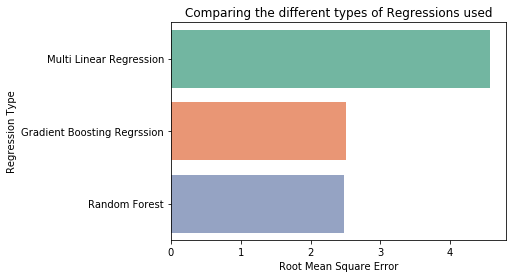

In [56]:
sns.barplot(regression['rmse'], regression['regression'], palette = 'Set2')
plt.xlabel("Root Mean Square Error")
plt.ylabel('Regression Type')
plt.title('Comparing the different types of Regressions used')